In [3]:
!pip install datasets
!pip install faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 107.6 MB/s eta 0:00:00


In [4]:
import torch
import gc
import faiss
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [5]:
!git clone https://github.com/brendenlake/SCAN.git

fatal: destination path 'SCAN' already exists and is not an empty directory.


In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = T5Tokenizer.from_pretrained("t5-small")
tokenizer.model_max_length = 1024
embed_model = SentenceTransformer('all-MiniLM-L6-v2').to(DEVICE)
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(DEVICE)

K_EXAMPLES = 5

model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [7]:
splits = [1, 2, 4, 8, 16, 32, 64, 100]
sequence_accs = []
token_accs = []

BATCH_SIZE = 32

In [16]:
for split in splits:
    print(f"\n{'='*20} RAG: Split p{split} {'='*20}")


    if split == 100:
        train_path = "/content/SCAN/simple_split/tasks_train_simple.txt"
        test_path = "/content/SCAN/simple_split/tasks_test_simple.txt"
    else:
        train_path = f"/content/SCAN/simple_split/size_variations/tasks_train_simple_p{split}.txt"
        test_path = f"/content/SCAN/simple_split/size_variations/tasks_test_simple_p{split}.txt"


    train_inputs, train_outputs = [], []
    with open(train_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" OUT: ")
            train_inputs.append(parts[0].replace("IN: ", ""))
            train_outputs.append(parts[1])


    print("Encoding Training Pool...")
    train_embeddings = embed_model.encode(train_inputs, show_progress_bar=True, convert_to_numpy=True)


    dimension = train_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(train_embeddings.astype('float32'))


    with open(test_path, 'r') as f:
        test_lines = f.readlines()

    seq_corr, tok_sum, count = 0, 0, 0

    print("Indexing Training Pool...")
    train_embs = embed_model.encode(train_inputs, batch_size=128, show_progress_bar=True)
    index = faiss.IndexFlatL2(train_embs.shape[1])
    index.add(train_embs.astype('float32'))


    test_cmds = [line.strip().split(" OUT: ")[0].replace("IN: ", "") for line in test_lines]
    test_targets = [line.strip().split(" OUT: ")[1].strip() for line in test_lines]

    print("Encoding Test Queries...")
    test_embs = embed_model.encode(test_cmds, batch_size=128, show_progress_bar=True)


    print("Searching FAISS Index...")
    _, all_indices = index.search(test_embs.astype('float32'), K_EXAMPLES)

    for i in tqdm(range(0, len(test_lines), BATCH_SIZE), desc="Generating Batches"):
        batch_indices = all_indices[i : i + BATCH_SIZE]
        batch_cmds = test_cmds[i : i + BATCH_SIZE]
        batch_targets = test_targets[i : i + BATCH_SIZE]

        prompts = []
        target_lens = []
        for j, test_cmd in enumerate(batch_cmds):
            prompt = "Translate SCAN to actions:\n"
            for train_idx in batch_indices[j]:
                prompt += f"{train_inputs[train_idx]} -> {train_outputs[train_idx]} |\n "
            prompt += f"{test_cmd} ->"
            prompts.append(prompt)
            target_lens.append(len(batch_targets[j].split()))


        inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to(DEVICE)


        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max(target_lens) + 5,
                num_beams=1,
                do_sample=False
            )

        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        if i == 0:
            print(f"\n{'#'*30} SAMPLE PREDICTIONS {'#'*30}")
            for k in range(min(3, len(preds))):
                print(f"\n[Test Sample {k}]")
                print(f"PROMPT:\n{prompts[k]}")
                print(f"INPUT CMD:  {batch_cmds[k]}")
                print(f"PREDICTION: {preds[k]}")
                print(f"TARGET:     {batch_targets[k]}")
                print(f"{'-'*70}")


        for pred, target, t_len in zip(preds, batch_targets, target_lens):
            pred = pred.strip()
            if pred == target: seq_corr += 1

            p_toks, t_toks = pred.split(), target.split()
            if t_toks:

                matches = sum(1 for p, t in zip(p_toks[:t_len], t_toks) if p == t)
                tok_sum += (matches / len(t_toks))
            count += 1



    print(f"p{split} Results -> Exact: {seq_corr/count:.4f}, Token Acc: {tok_sum/count:.4f}")

    sequence_accs.append(seq_corr/count)
    token_accs.append(tok_sum/count)

    del train_embs, test_embs, index
    gc.collect()
    torch.cuda.empty_cache()


==================== RAG: Split p1 ====================
Encoding Training Pool...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/162 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/647 [00:00<06:36,  1.63it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
walk twice and turn opposite left -> I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT |
 turn opposite left twice after walk opposite left twice -> I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 walk opposite right twice and turn around left thrice -> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 turn opposite left twice after walk around left twice -> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 walk twice after walk opposite right twice -> I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_

Generating Batches: 100%|██████████| 647/647 [07:49<00:00,  1.38it/s]


p1 Results -> Exact: 0.0000, Token Acc: 0.1437

==================== RAG: Split p2 ====================
Encoding Training Pool...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/161 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/641 [00:00<06:58,  1.53it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
turn around left twice and run left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN |
 run right twice after turn left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN |
 run opposite right twice after turn left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN |
 run left twice after turn left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN |
 turn left twice and run left thrice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN |
 run left and turn right twice ->
INPUT CMD:  run left and turn right twice
PREDICTION: : turn around left twice and run left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN
TARGET:     I_TURN_LEFT I_RUN I_TURN_RI

Generating Batches: 100%|██████████| 641/641 [07:47<00:00,  1.37it/s]


p2 Results -> Exact: 0.0000, Token Acc: 0.1366

==================== RAG: Split p4 ====================
Encoding Training Pool...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/628 [00:00<08:55,  1.17it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
jump left twice after walk around left thrice -> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP |
 jump left thrice after walk around right twice -> I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP |
 jump twice after walk left thrice -> I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_JUMP I_JUMP |
 jump right twice after walk around right thrice -> I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_W

Generating Batches: 100%|██████████| 628/628 [07:49<00:00,  1.34it/s]


p4 Results -> Exact: 0.0000, Token Acc: 0.1310

==================== RAG: Split p8 ====================
Encoding Training Pool...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/602 [00:00<08:07,  1.23it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
run around right after jump right thrice -> I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN |
 run thrice and jump around right thrice -> I_RUN I_RUN I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP |
 jump around right thrice after run twice -> I_RUN I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP |
 run thrice after jump around left -> I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TUR

Generating Batches: 100%|██████████| 602/602 [07:32<00:00,  1.33it/s]


p8 Results -> Exact: 0.0000, Token Acc: 0.1188

==================== RAG: Split p16 ====================
Encoding Training Pool...


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/549 [00:00<08:19,  1.10it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
walk right thrice and run opposite right twice -> I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN |
 run opposite right thrice and walk right twice -> I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK |
 run opposite right twice and walk thrice -> I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_WALK I_WALK I_WALK |
 run right thrice and walk opposite right twice -> I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK |
 run opposite left thrice and walk twice -> I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_WALK I_WALK |
 walk opposite right thrice and run twice -

Generating Batches: 100%|██████████| 549/549 [06:54<00:00,  1.33it/s]


p16 Results -> Exact: 0.0000, Token Acc: 0.1106

==================== RAG: Split p32 ====================
Encoding Training Pool...


Batches:   0%|          | 0/210 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/53 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/112 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/445 [00:00<04:46,  1.55it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
turn opposite right thrice after run opposite left twice -> I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT |
 turn opposite left twice after run opposite right thrice -> I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 run opposite left thrice after turn opposite left twice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN |
 turn opposite left twice after run left thrice -> I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 run opposite left thrice after turn opposite right twice -> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TU

Generating Batches: 100%|██████████| 445/445 [05:36<00:00,  1.32it/s]


p32 Results -> Exact: 0.0000, Token Acc: 0.1074

==================== RAG: Split p64 ====================
Encoding Training Pool...


Batches:   0%|          | 0/419 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   0%|          | 1/236 [00:00<03:15,  1.20it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
run right thrice after run around right twice -> I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN |
 run around right twice after run right thrice -> I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN |
 run thrice after run around right twice -> I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_RUN I_RUN I_RUN |
 run around right thrice after run around right twice -> I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_

Generating Batches: 100%|██████████| 236/236 [02:58<00:00,  1.32it/s]


p64 Results -> Exact: 0.0000, Token Acc: 0.1056

==================== RAG: Split p100 ====================
Encoding Training Pool...


Batches:   0%|          | 0/523 [00:00<?, ?it/s]

Indexing Training Pool...


Batches:   0%|          | 0/131 [00:00<?, ?it/s]

Encoding Test Queries...


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Searching FAISS Index...


Generating Batches:   1%|          | 1/131 [00:00<01:26,  1.51it/s]


############################## SAMPLE PREDICTIONS ##############################

[Test Sample 0]
PROMPT:
Translate SCAN to actions:
turn opposite left thrice and turn opposite right -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT |
 turn opposite right and turn opposite left thrice -> I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 turn opposite left thrice and turn right -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT |
 turn opposite right thrice and turn opposite right -> I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT |
 turn opposite left and turn opposite left thrice -> I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT |
 turn opposite right thrice and turn opposite left ->
INPUT CMD:  turn opposite right thrice and turn opposite left

Generating Batches: 100%|██████████| 131/131 [01:40<00:00,  1.31it/s]


p100 Results -> Exact: 0.0000, Token Acc: 0.1087


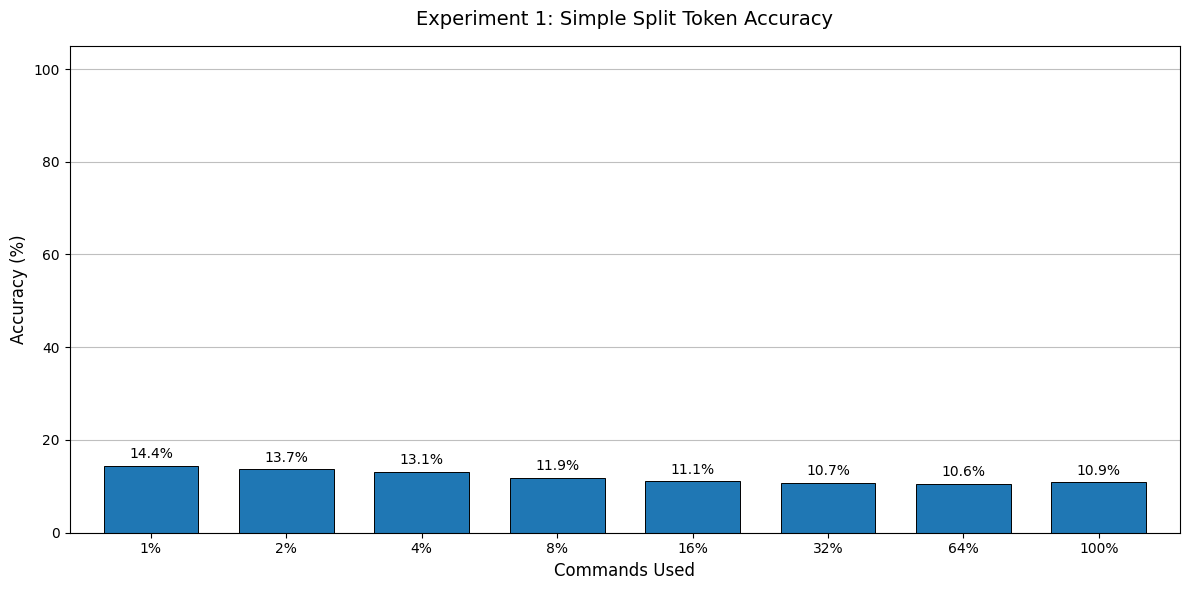

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plot_accs = [acc * 100 for acc in token_accs]

bars = plt.bar(splits, plot_accs, color='#1f77b4', edgecolor='black', linewidth=0.7, width=0.7)


plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Experiment 1: Simple Split Token Accuracy', fontsize=14, pad=15)


plt.xlim(-0.6, len(splits) - 0.4)
plt.ylim(0, 105)


plt.grid(axis='y', linestyle='-', alpha=0.8)
plt.gca().set_axisbelow(True)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()


plt.savefig('experiment_1_results.png', dpi=300, bbox_inches='tight')
plt.show()